In [2]:
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import functools
import os
import bz2
import json
import numpy as np

In [8]:
def load_df(dir_path, day, targets=None):
    invocation_fpattern = "invocations_per_function_md.anon.d%02d.csv"
    df = pd.read_csv(dir_path.joinpath(invocation_fpattern % day))
    if targets is None:
        return df
    else:
        return df[df.HashFunction.isin(targets)].sort_values("HashFunction").reset_index(drop=True)

target_dir = Path("/srv/local/bj2/azure_2019")

dfs = {}
for i in range(1, 15):
    dfs[i] = load_df(target_dir, i, targets=None)
original_dfs = dfs

In [9]:
from functools import reduce
import numpy as np

functions = {d: df.HashFunction.unique() for d, df in original_dfs.items()}
target_funcs = reduce(np.intersect1d, functions.values())

In [11]:
sample8_keys = [#'12f4b1fc58f4a13b0e5bc8d854c0b9cf9abd7422082631bfec2787ebb7ffb928', 
"2c5d363481a100391a50d5397fece786de8d4b86fc02c8880a78bcfa7b297139", #'33c62168d74030abe560c3ad9d3281a040db4ff5eb2006e423afb99e129c6ee9', 
'e3207d8e111207a6411ab78f0523b4b0f7a20689410cfdfa9fb7c1216ee84841', 
'c531d4a648804161bb266dc5e338e80ed8287f50ae1443cfa3d065b348970163', 
'e0bcfea24c34654ffc13a9bd43681b6e1b89a608fcc5b014a27e3572621fc5d3',
'a4cd330134a6d4973a5cbbd2ba5e77ddf52f31a920a853ee4ddd80ecf0c6edca',
'bd33ce4bbd8f9ee2f2635a94bc3b0ec5a17739e4ad551851cc44b90cecf2eada',
'9c61f9602abec110d851deb280a65bbd7b2f4916178bacd3d94a477f457565f1',
'f44479dabd4b8c6e1d354265aa81e62cde0bf0d8bcefb07f53dd717cfc911c8f',
'41d5874c93e42b71124b2cc6439e6f6fdb5920e67163eebef372593b878741f8',
'd0bc823aa847a9141ebcbd48d7d80cc3c8c3018f492b9f25648c39b1601b845b',
'01f168c5b136e70fd2bedb60838a82e9f03a88952f4b47ba05cf2e19533f351d']
sample_keys = np.intersect1d(target_funcs, sample8_keys)
print(len(sample_keys))
# sample_keys = np.random.choice(target_funcs, 10)
target_dfs = {i: dfs[i] for i in range(1, 12)}

9


In [77]:
from collections import defaultdict
from tqdm import tqdm

count_dict = defaultdict(int)

# target_dfs = dfs

for df in tqdm(target_dfs.values()):
    target_df = df[df.HashFunction.isin(target_funcs)]
    for f, c in zip(target_df.HashFunction, target_df.sum(axis=1)):
        count_dict[f] += c

  0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_45301/3758554217.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  for f, c in zip(target_df.HashFunction, target_df.sum(axis=1)):
100%|██████████| 14/14 [01:04<00:00,  4.63s/it]


In [81]:
tops = sorted([(v, k) for k, v in count_dict.items()], reverse=True)[:1000]
top_counts, top_keys = zip(*tops)
sample_keys = np.random.choice(top_keys, 10)
# print(top_keys)

In [28]:
# exp_target = target_dfs[max(target_dfs.keys())]
# exp_target = exp_target[exp_target.HashFunction.isin(top_keys)].reset_index()
# sample_keys = exp_target.iloc[exp_target.std(axis=1).sort_values(ascending=False)[:9].index].HashFunction.values

/tmp/ipykernel_45301/1786158952.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sample_keys = exp_target.iloc[exp_target.std(axis=1).sort_values(ascending=False)[:9].index].HashFunction.values
/tmp/ipykernel_45301/1786158952.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sample_keys = exp_target.iloc[exp_target.std(axis=1).sort_values(ascending=False)[:9].index].HashFunction.values


In [12]:
def parse_df(df, day):
    keys = []
    counts = []
    for _, s in df.iterrows():
        keys.append(s["HashFunction"])
        counts.append(np.array([s[str(i)] for i in np.arange(1, 1441)], dtype=np.int32))

    counts = [pd.Series(c, dtype=np.int32) for c in counts]
    return pd.DataFrame({"hash_func": keys, "day": np.repeat(day, len(keys)), "counts": counts})

parsed_dfs = {day: parse_df(df[df.HashFunction.isin(sample_keys)], day) for day, df in target_dfs.items()}

In [13]:
def generate_count_dict(dfs):
    counts_dict = defaultdict(list)

    for day, df in sorted(dfs.items()):
        for _, row in df.iterrows():
            counts_dict[row.hash_func].append(row.counts)

    return {
        hash_func: pd.concat(counts).reset_index(drop=True) for hash_func, counts in counts_dict.items()
    }

unscaled_count_dict = generate_count_dict(parsed_dfs)

In [98]:
def scale1d(count, target=50, limit_only=False):
    if limit_only:
        if np.max(count) > target:
            # normalize and remap to [0, target]
            new_count = count / np.max(count) * target
            return np.round(new_count).astype(np.int32)
        else:
            return count
    else:
        new_count = count / np.max(count) * target
        return np.round(new_count).astype(np.int32)

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaled_count_dict = {
    k: np.round(MinMaxScaler(feature_range=(1, 40)).fit_transform(np.expand_dims(v, -1))).astype(np.int32)
    for k, v in unscaled_count_dict.items()
}

In [100]:
# avgs = {k: v.mean() for k, v in scaled_count_dict.items()}
# top_avgs = sorted([(v, k) for k, v in avgs.items()], reverse=True)[:5]
# _, top_keys = zip(*top_avgs)
# filtered_scaled_count_dict = {k: v for k, v in scaled_count_dict.items() if k in top_keys}

In [101]:
# stds = {k: v.std() for k, v in scaled_count_dict.items()}
# top_stds = sorted([(v, k) for k, v in stds.items()], reverse=True)[:10]
# _, sample_keys = zip(*top_stds)
# sample_keys = np.random.choice(top_keys, 9)
filtered_scaled_count_dict = {k: v for k, v in scaled_count_dict.items() if k in sample_keys}

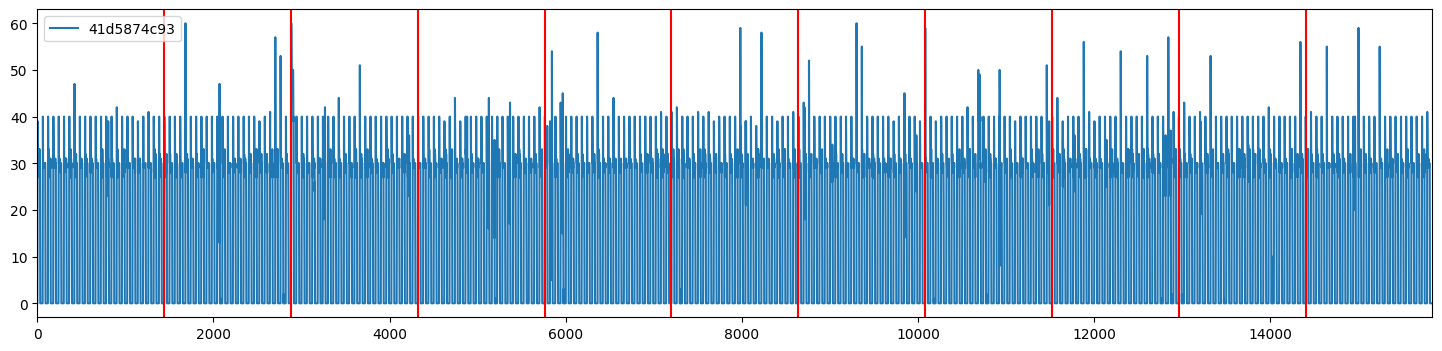

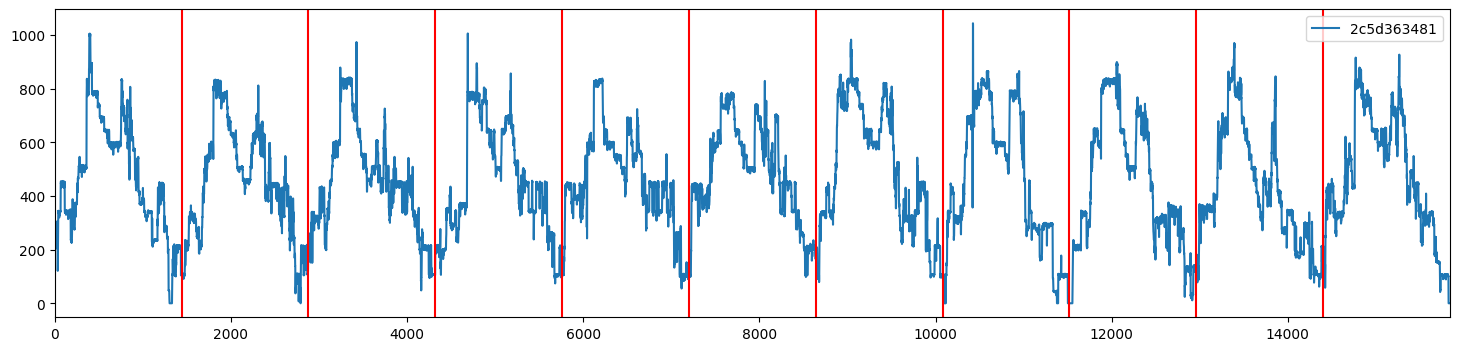

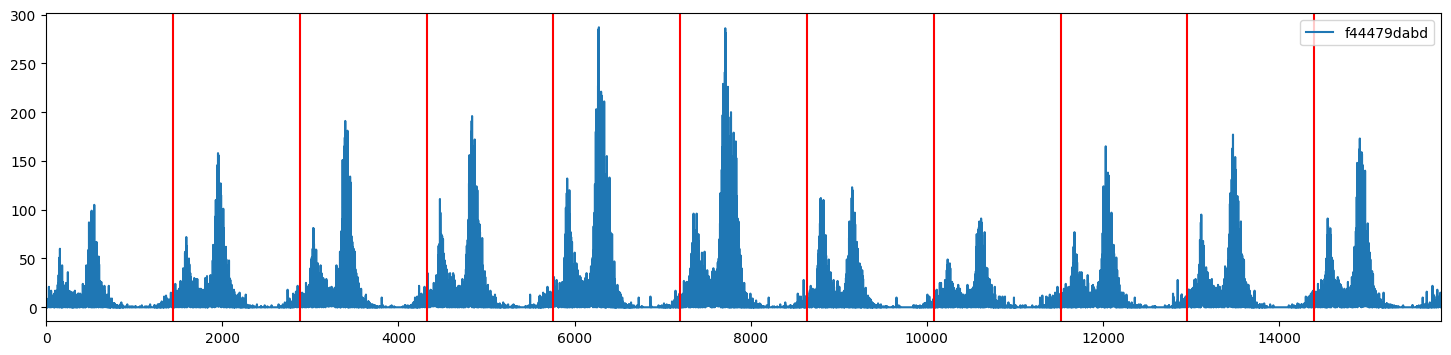

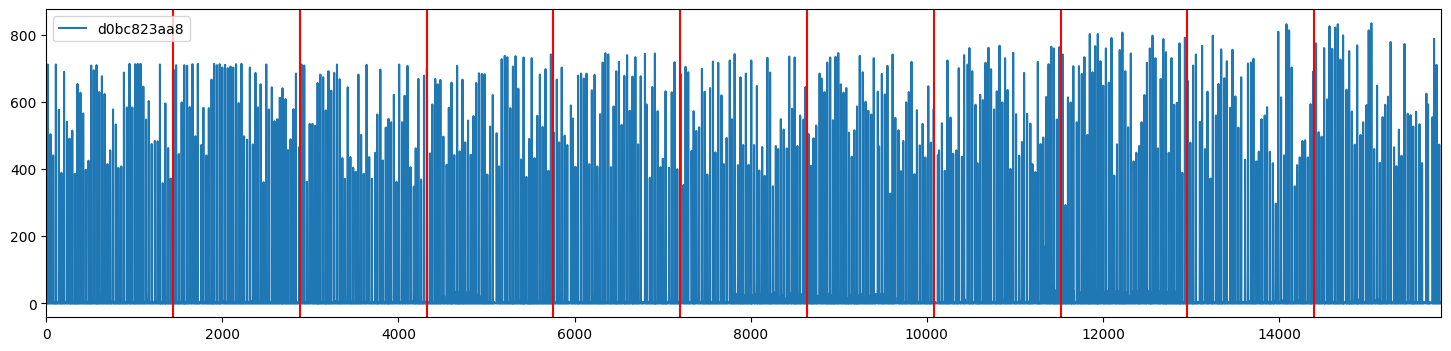

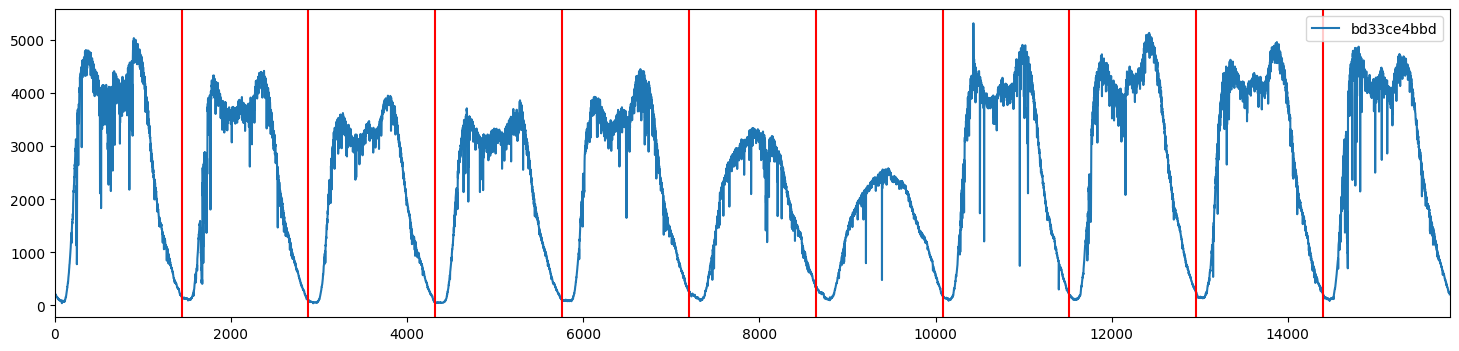

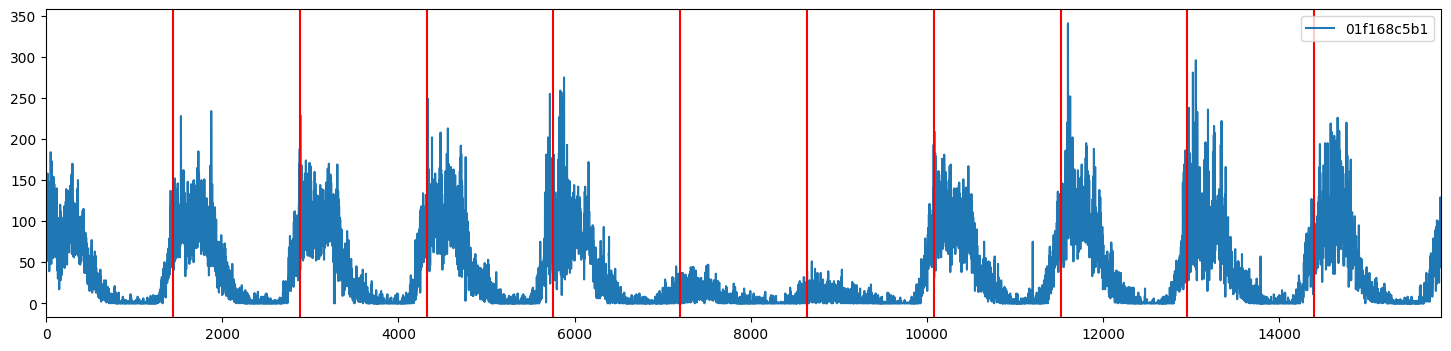

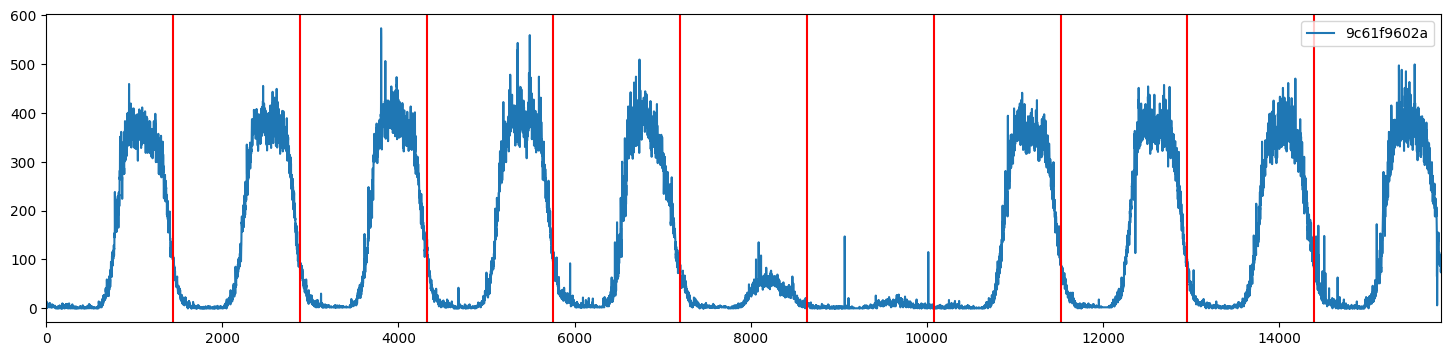

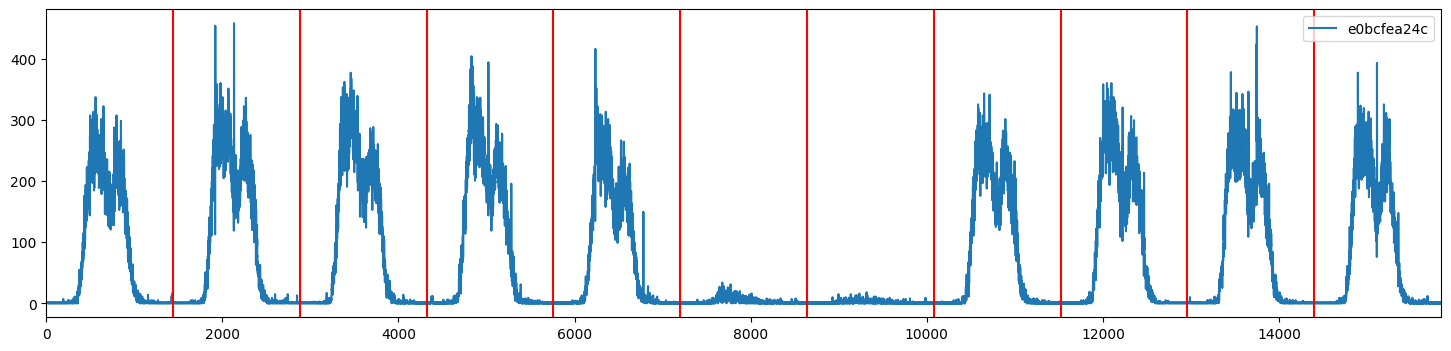

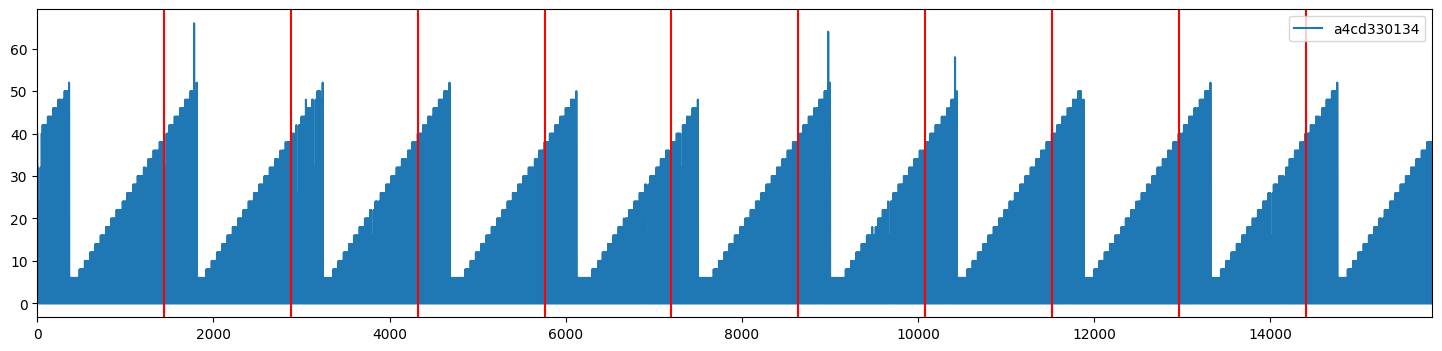

In [14]:
def plot(counts_dict):
    for hash_func, counts in counts_dict.items():
        fig, ax = plt.subplots(figsize=(18, 4))
        ax.plot(counts, label=hash_func[:10])
        ax.set_xlim(0, len(counts))
        for i in range(1440, len(counts), 1440):
            ax.axvline(i, color="red")
        ax.legend()

# plot(filtered_scaled_count_dict)
plot(unscaled_count_dict)

In [15]:
parsed_twitter_dir = Path("/home/bj2/k8s-ray-py/data/infaas")
target_txts = [
    parsed_twitter_dir.joinpath("twitter_04_%02d.txt" % d)
    for d in range(1, 1 + 11)
]

In [16]:
counts = [
    [int(line.split(" ")[1]) for line in target_txt.read_text().splitlines()]
    for target_txt in target_txts]
total_counts = np.concatenate(counts)
# print(len(counts))
# print(len(total_counts))
scaled_counts = total_counts
# scaled_counts = np.round(MinMaxScaler(feature_range=(1, 40)).fit_transform(np.expand_dims(total_counts, -1))).astype(np.int32)

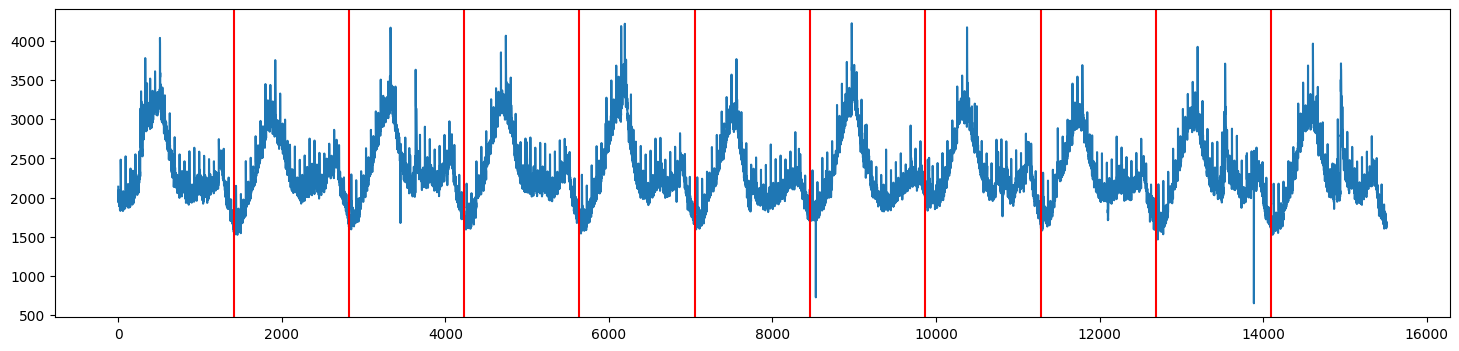

In [17]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(scaled_counts)
for i in range(1410, len(scaled_counts), 1410):
    ax.axvline(i, color="red")

In [18]:
for i, count in enumerate(counts, 1):
    target_df = parsed_dfs[i]
    target_df.loc[len(target_df.index)] = ["twitter", i, pd.Series(count)]

In [19]:
pd.concat(parsed_dfs.values()).to_pickle("azure_twitter_unscaled_sample.pkl")
#  pd.concat(parsed_dfs.values()).to_pickle("top9_twitter_unscaled_sample.pkl")